## Data Analysis of Head Start Accessibility across the Continental U.S.

- Presented by <b>Data Miners</b> for <b>2023 AGA Datathon</b>

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import sys
import geopy.distance
from itertools import combinations

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Loading Datasets

##### List of data source:
- Head Start Program Facts: Fiscal Year 2021: https://eclkc.ohs.acf.hhs.gov/about-us/article/head-start-program-facts-fiscal-year-2021

- Head Start Center Locations: https://eclkc.ohs.acf.hhs.gov/about-us/article/head-start-center-location-datasets

- SAIPE Child Poverty Data: https://www.census.gov/data/datasets/2021/demo/saipe/2021-state-and-county.html

In [153]:
df_headstart_fiscal = pd.read_html('https://eclkc.ohs.acf.hhs.gov/about-us/article/head-start-program-facts-fiscal-year-2021')
df_headstart_fiscal =  df_headstart_fiscal[1].iloc[2:, :3]
df_headstart_fiscal.columns = ['state', 'enroll_amount', 'enroll_count', ]
df_headstart_fiscal.head()

,state,enroll_amount,enroll_count
2,Alabama,"$156,825,889",13438
3,Alaska,"$20,579,547",1348
4,Arizona,"$175,213,573",13054
5,Arkansas,"$106,372,981",9191
6,California,"$1,320,500,737",87819


#### Metric: Fund per child
- Definition: The total amount of head start program fund divided by the number of children enrolled in the head start centers within a state.
- Usage: 
- - Shows the distribution of fiscal resource across the states. 
- - Identify states that are overfunded and underfunded.

In [154]:
df_headstart_fiscal['fund_per_child'] = np.round(df_headstart_fiscal.enroll_amount.map(lambda s: float(s[1:].replace(',', ''))) / df_headstart_fiscal.enroll_count.astype(float), 3)
df_headstart_fiscal.head()

,state,enroll_amount,enroll_count,fund_per_child
2,Alabama,"$156,825,889",13438,11670.330
3,Alaska,"$20,579,547",1348,15266.726
4,Arizona,"$175,213,573",13054,13422.213
5,Arkansas,"$106,372,981",9191,11573.603
6,California,"$1,320,500,737",87819,15036.618


In [155]:
df_headstart_center = pd.read_csv('ALL_all.csv',)

In [156]:
df_headstart_center.columns

Index(['addressLineOne', 'addressLineTwo', 'cid', 'grantNumber',
       'delegateNumber', 'type', 'longitude', 'latitude', 'name', 'city',
       'state', 'zipFive', 'zipFour', 'phone', 'googleMapZoomLevel', 'county',
       'programCounty', 'programAddressLineOne', 'programAddressLineTwo',
       'programName', 'programCity', 'programState', 'programZipFive',
       'programZipFour', 'programPhone', 'programRegistrationPhone',
       'programIdentifier'],
      dtype='object')

In [157]:
# to perform county level analysis, we need to combine state and county so as to make it unique
df_headstart_center['state_county'] = df_headstart_center['state'] + " " + df_headstart_center['county']

In [158]:
df_headstart_center.shape, df_headstart_center.cid.nunique(), df_headstart_center.state_county.nunique()

((21334, 28), 21334, 2895)

In [159]:
df_headstart_center.head()

,addressLineOne,addressLineTwo,cid,grantNumber,delegateNumber,type,longitude,latitude,name,city,...,programAddressLineTwo,programName,programCity,programState,programZipFive,programZipFour,programPhone,programRegistrationPhone,programIdentifier,state_county
0,11500 Joslin St,NaN,100000,09CH011157,2,1,-118.089,33.944,Lakeview (Plaza),Santa Fe Springs,...,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 929-6320,(562)776-1301,los_angeles_county_office_of_education_ca,CA Los Angeles County
1,5036 North Huntington Drive,NaN,100001,09CH011157,2,1,-118.172,34.089,El Sereno (Plaza),Los Angeles,...,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(323) 222-2786,(562)776-1301,los_angeles_county_office_of_education_ca,CA Los Angeles County
2,2141 Workman St,NaN,100002,09CH011157,2,1,-118.214,34.071,Cedillo (Plaza),Los Angeles,...,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(323) 225-9792,(562)776-1301,los_angeles_county_office_of_education_ca,CA Los Angeles County
3,12322 Pellissier Rd,NaN,100003,09CH011157,2,1,-118.032,34.034,Little Star (Plaza),Whittier,...,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 699-5655,(562)776-1301,los_angeles_county_office_of_education_ca,CA Los Angeles County
4,12830 Columbia Way,NaN,100004,09CH011157,2,1,-118.134,33.914,Columbia (Plaza),Downey,...,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 803-6229,(562)776-1301,los_angeles_county_office_of_education_ca,CA Los Angeles County


In [160]:
df_statewise_children_poverty = pd.read_csv('state-wise-poverty-child.csv')

In [161]:
df_statewise_children_poverty.head()

,Year,ID,Name,Poverty Universe,Number in Poverty,90% Confidence Interval,Percent in Poverty,90% Confidence Interval.1
0,2021,0,United States,72297129,12243219,"12,110,180 to 12,376,258",16.900,16.7 to 17.1
1,2021,1000,Alabama,1104114,250327,"241,921 to 258,733",22.700,21.9 to 23.5
2,2021,2000,Alaska,176238,23760,"22,273 to 25,247",13.500,12.7 to 14.3
3,2021,4000,Arizona,1584388,281696,"271,479 to 291,913",17.800,17.2 to 18.4
4,2021,5000,Arkansas,689113,150353,"144,623 to 156,083",21.800,21.0 to 22.6


In [162]:
df_state_abbr = pd.read_csv('states-abbr.csv')

In [163]:
df_state_abbr.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [164]:
df_saipe = pd.read_excel('est21all.xls',).drop(index=[0, 1])

In [165]:
df_saipe.head()

,Table with column headers in rows 3 and 4,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
2,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,...,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
3,00,000,US,United States,41393176,41149497,41636855,12.800,12.700,12.900,...,16.300,69717,69583,69851,3349149,3299669,3398629,18.300,18,18.600
4,01,000,AL,Alabama,800848,782169,819527,16.300,15.900,16.700,...,22.500,53990,53218,54762,71220,66888,75552,25.100,23.600,26.600
5,01,001,AL,Autauga County,6296,4772,7820,10.700,8.100,13.300,...,20.400,66444,60061,72827,.,.,.,.,.,.
6,01,003,AL,Baldwin County,25526,21599,29453,10.800,9.100,12.500,...,18.500,65658,60723,70593,.,.,.,.,.,.


In [166]:
state_names = df_state_abbr.State.tolist()
filter_out = state_names + ['United States']
df_saipe = df_saipe[~df_saipe['Unnamed: 3'].isin(filter_out)]
df_saipe.head()

,Table with column headers in rows 3 and 4,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
2,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,...,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
5,01,001,AL,Autauga County,6296,4772,7820,10.700,8.100,13.300,...,20.400,66444,60061,72827,.,.,.,.,.,.
6,01,003,AL,Baldwin County,25526,21599,29453,10.800,9.100,12.500,...,18.500,65658,60723,70593,.,.,.,.,.,.
7,01,005,AL,Barbour County,5089,3773,6405,23,17,29,...,44.600,38649,34308,42990,.,.,.,.,.,.
8,01,007,AL,Bibb County,4204,3324,5084,20.600,16.300,24.900,...,35.400,48454,42438,54470,.,.,.,.,.,.


In [167]:
def to_int(v):
    try:
        return int(v)
    except Exception as e:
        print(e)
        print(v)
        return 0

In [168]:
teen_poverty = df_saipe.iloc[1:, 10].map(to_int)
teen_poverty

young_poverty = df_saipe.iloc[1:, 16].map(to_int)
young_poverty

child_poverty = teen_poverty - young_poverty
child_poverty

invalid literal for int() with base 10: '.'
.
invalid literal for int() with base 10: '.'
.


5        592
6       2445
7        500
8        335
9        637
        ... 
3193     320
3194      81
3195     221
3196      59
3197      54
Length: 3142, dtype: int64

In [169]:
df_child_poverty = pd.DataFrame({
    'state': df_saipe.iloc[1:, 2],
    'county': df_saipe.iloc[1:, 3],
    'county_fips': df_saipe.iloc[1:, 0],
    'child_poverty_count': child_poverty.values,
})

df_child_poverty.head()

,state,county,county_fips,child_poverty_count
5,AL,Autauga County,01,592
6,AL,Baldwin County,01,2445
7,AL,Barbour County,01,500
8,AL,Bibb County,01,335
9,AL,Blount County,01,637


In [170]:
df_child_poverty[df_child_poverty.county.str.contains('County|Parish')]

,state,county,county_fips,child_poverty_count
5,AL,Autauga County,01,592
6,AL,Baldwin County,01,2445
7,AL,Barbour County,01,500
8,AL,Bibb County,01,335
9,AL,Blount County,01,637
...,...,...,...,...
3193,WY,Sweetwater County,56,320
3194,WY,Teton County,56,81
3195,WY,Uinta County,56,221
3196,WY,Washakie County,56,59


In [171]:
df_child_poverty = pd.merge(df_child_poverty, df_state_abbr, left_on='state', right_on='Abbreviation', how='left',).drop(columns=['Abbreviation'])
col = df_child_poverty.columns.tolist()
col[-1] = 'state_name'
df_child_poverty.columns = col

df_child_poverty['state_county'] = df_child_poverty.state + ' ' + df_child_poverty.county
print(df_child_poverty.shape, df_child_poverty.state_county.nunique()   )
df_child_poverty.head()

(3142, 6) 3142


,state,county,county_fips,child_poverty_count,state_name,state_county
0,AL,Autauga County,01,592,Alabama,AL Autauga County
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County
2,AL,Barbour County,01,500,Alabama,AL Barbour County
3,AL,Bibb County,01,335,Alabama,AL Bibb County
4,AL,Blount County,01,637,Alabama,AL Blount County


##### Metric: Children per Center (CPC)
- Definition: The number of enrolled children divided by the number of centers. Can be calculated at either county or state level. In this analysis it is calculated at county level.
- Usage: Evaluate the average workload of head start centers within a region. If the metric goes too high, the children in the corresponding area may be underserved. If the metric goes too low, the centers in the corresponding area may not be fully utilized.

In [172]:
# def get_center_util_rate(children:float, centers: float):
#     if children == 0 or children == np.nan:
#         children = 1e-3
#     return round(centers / children, 5)


def get_child_per_center(children:float, centers: float):
    if centers == 0 or centers == np.nan:
        return np.nan
    return round(children / centers, 5)


# def find_cur(index):
#     state_county = df_child_poverty.loc[index, 'state_county']
#     count_children = df_child_poverty.loc[index, 'child_poverty_count']
#     count_centers = df_headstart_center[df_headstart_center.state_county == state_county].shape[0]
#     return get_center_util_rate(count_children, count_centers)


def find_cpc(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    count_children = df_child_poverty.loc[index, 'child_poverty_count']
    count_centers = df_headstart_center[df_headstart_center.state_county == state_county].shape[0]
    return get_child_per_center(count_children, count_centers)

def check_has_center(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    count_centers = df_headstart_center[df_headstart_center.state_county == state_county].shape[0]
    return count_centers > 0


# def find_adj_cur(index):
#     state_county = df_child_poverty.loc[index, 'state_county']
#     pos_county_centers = df_headstart_center[df_headstart_center.state_county == state_county][['latitude', 'longitude']].values
#     county_cur = df_child_poverty.loc[index, 'cur']
    
#     def find_distance(index):
#         pos = df_headstart_center.loc[index, ['latitude', 'longitude']].values
#         arr_dist = [geopy.distance.geodesic(pos_center, pos).miles for pos_center in pos_county_centers]
#         arr_dist = list(filter(lambda x: x > 0, arr_dist))
#         return min(arr_dist) if arr_dist else -1

#     df_temp = df_headstart_center[~df_headstart_center.state_county.isin([state_county])]
#     df_temp['dist_miles'] = df_temp.index.map(find_distance)
#     df_temp = df_temp[(df_temp.dist_miles < 8) & (df_temp.dist_miles > 0)]
#     if df_temp.shape[0] > 0:
#         adjacent_counties = df_temp.state_county.unique()
#         acur = 0.7 * county_cur + df_child_poverty[df_child_poverty.state_county in adjacent_counties].center_util_rate.mean()  * 0.3
#     else:
#         acur = county_cur
#     return acur


# df_child_poverty['cur'] = df_child_poverty.index.map(find_cur)
df_child_poverty['cpc'] = df_child_poverty.index.map(find_cpc)
df_child_poverty['has_center'] = df_child_poverty.index.map(check_has_center)
df_child_poverty.head()

,state,county,county_fips,child_poverty_count,state_name,state_county,cpc,has_center
0,AL,Autauga County,01,592,Alabama,AL Autauga County,296.000,True
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County,489.000,True
2,AL,Barbour County,01,500,Alabama,AL Barbour County,500.000,True
3,AL,Bibb County,01,335,Alabama,AL Bibb County,335.000,True
4,AL,Blount County,01,637,Alabama,AL Blount County,127.400,True


In [173]:
df_child_poverty.shape[0], df_child_poverty.county.nunique()

(3142, 1877)

<AxesSubplot:ylabel='Frequency'>

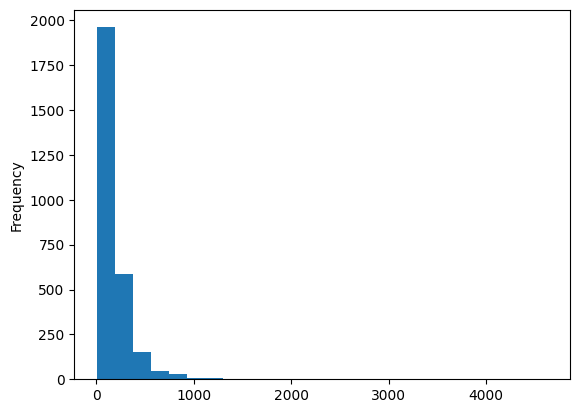

In [174]:
df_child_poverty.cpc.plot(kind='hist', bins=25)

In [175]:
df_county_boundaries = pd.read_html('https://en.wikipedia.org/wiki/User:Michael_J/County_table')[0].iloc[:, 1:]

In [176]:
def to_float(s):
    try:
        return float(s.replace('–', '-'))
    except Exception as e:
        print(e)
        print(s)
        return 0


col = df_county_boundaries.columns.map(lambda s: s.lower()).tolist()
col[2] = 'county'
df_county_boundaries.columns = col
df_county_boundaries.latitude = df_county_boundaries.latitude.map(lambda s: to_float(s[:-1]))
df_county_boundaries.longitude = df_county_boundaries.longitude.map(lambda s: to_float(s[:-1]))
df_county_boundaries.head()

,state,fips,county,county seat(s) [3],population(2010),land areakm²,land areami²,water areakm²,water areami²,total areakm²,total areami²,latitude,longitude
0,AL,1001,Autauga,Prattville,54571,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536,-86.644
1,AL,1003,Baldwin,Bay Minette,182265,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,30.659,-87.746
2,AL,1005,Barbour,Clayton,27457,2291.819,884.876,50.865,19.639,2342.684,904.515,31.871,-85.405
3,AL,1007,Bibb,Centreville,22915,1612.481,622.582,9.289,3.587,1621.770,626.169,33.016,-87.127
4,AL,1009,Blount,Oneonta,57322,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977,-86.567


In [177]:
df_county_boundaries['state_county'] = df_county_boundaries.state + ' ' + df_county_boundaries.county + " County"
df_child_poverty = pd.merge(df_child_poverty, df_county_boundaries[['state_county', 'latitude', 'longitude']], on='state_county', how='left')
df_child_poverty.head()

,state,county,county_fips,child_poverty_count,state_name,state_county,cpc,has_center,latitude,longitude
0,AL,Autauga County,01,592,Alabama,AL Autauga County,296.000,True,32.536,-86.644
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County,489.000,True,30.659,-87.746
2,AL,Barbour County,01,500,Alabama,AL Barbour County,500.000,True,31.871,-85.405
3,AL,Bibb County,01,335,Alabama,AL Bibb County,335.000,True,33.016,-87.127
4,AL,Blount County,01,637,Alabama,AL Blount County,127.400,True,33.977,-86.567


In [178]:
no_pos_state_county = df_child_poverty[df_child_poverty.latitude.isna() | df_child_poverty.longitude.isna()]['state_county']
df_avg_pos = df_headstart_center[df_headstart_center.state_county.isin(no_pos_state_county)].groupby('state_county').agg({'latitude': 'mean', 'longitude': 'mean'})


def find_lat(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    if state_county not in df_avg_pos.index:
        return np.nan
    lat = df_avg_pos.loc[state_county, 'latitude']
    return lat

def find_long(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    if state_county not in df_avg_pos.index:
        return np.nan
    long = df_avg_pos.loc[state_county, 'longitude']
    return long

df_child_poverty.loc[df_child_poverty.latitude.isna(), 'latitude'] = df_child_poverty[df_child_poverty.latitude.isna()].index.map(find_lat)
df_child_poverty.loc[df_child_poverty.longitude.isna(), 'longitude'] = df_child_poverty[df_child_poverty.longitude.isna()].index.map(find_long)
df_child_poverty.latitude.isna().sum(), df_child_poverty.longitude.isna().sum()

(32, 32)

In [179]:
df_child_poverty = df_child_poverty[~(df_child_poverty.latitude.isna() | df_child_poverty.longitude.isna()) & df_child_poverty.state_county.str.contains('County|Parish')]

In [180]:
df_child_poverty.shape

(3063, 10)

In [181]:
df_child_poverty.latitude.isna().sum(), df_child_poverty.longitude.isna().sum()

(0, 0)

##### Metric: Center Coverage Rate
- Definition: The number of regions where head start is available divided by the number of regions. The regions can be either county, state, or other well-defined unit. In our analysis it is calculated at county level.
- Usage: Gives an overall idea of the accessibility of head start program across the nation.

In [182]:
df_child_poverty.has_center.mean()

0.8971596474045054

##### Metric: Enrollment Rate
- Definition: The number of children enrolled in the head start centers of a county divided by the estimated number of children in poverty in the same county.
- Usage: Shows how many community members are actually participating in the head start program in a county.

In [183]:
df_state_child_poverty = df_child_poverty.groupby('state')['child_poverty_count'].sum().to_frame()
df_state_child_poverty.reset_index(inplace=True)
df_state_child_poverty = pd.merge(df_state_child_poverty, df_state_abbr, left_on='state',  right_on='Abbreviation', how='left').drop(columns=['Abbreviation'])
col = df_state_child_poverty.columns.tolist()
col[-1] = 'state_name'
df_state_child_poverty.columns = col
df_state_child_poverty = pd.merge(df_state_child_poverty, df_headstart_fiscal, left_on='state_name', right_on='state', how='left', suffixes=('', '_headstart')).drop(columns=['state_headstart'])
df_state_child_poverty['enroll_rate'] = df_state_child_poverty.enroll_count.astype(float) / df_state_child_poverty.child_poverty_count.astype(float)
df_state_child_poverty.head()

,state,child_poverty_count,state_name,enroll_amount,enroll_count,fund_per_child,enroll_rate
0,AL,73733,Alabama,"$156,825,889",13438,11670.330,0.182
1,AR,47630,Arkansas,"$106,372,981",9191,11573.603,0.193
2,AZ,83855,Arizona,"$175,213,573",13054,13422.213,0.156
3,CA,369418,California,"$1,320,500,737",87819,15036.618,0.238
4,CO,44499,Colorado,"$119,296,359",9489,12572.069,0.213


In [184]:
df_child_poverty.to_csv('child_poverty_merged_10-22.csv', index=False)

In [185]:
df_state_child_poverty.to_csv('enroll_and_fund.csv', index=False)

#### Statistical Analysis:
##### Distribution of Children per Center
- Skewed to the right, meaning that there are few counties with abnormaly high figures of children per center. 
- Managers may need to focus on those counties and try to provide more resource so as to serve the communities there.

<AxesSubplot:>

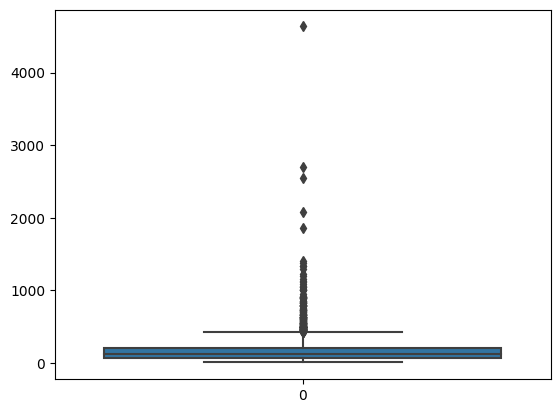

In [186]:
sns.boxplot(df_child_poverty['cpc'],)

In [187]:
df_child_poverty.cpc.describe()

count   2748.000
mean     174.692
std      202.530
min        5.667
25%       67.394
50%      120.342
75%      211.808
max     4635.000
Name: cpc, dtype: float64

In [188]:
df_child_poverty[['cpc','state', 'state_county']].sort_values(ascending=False, by='cpc' ).head(10)

,cpc,state,state_county
2583,4635.000,TX,TX Denton County
2645,2693.000,TX,TX Jefferson County
2565,2543.000,TX,TX Collin County
419,2078.667,GA,GA Cobb County
1954,1857.000,NC,NC New Hanover County
453,1406.429,GA,GA Gwinnett County
1214,1383.000,MD,MD Wicomico County
455,1333.000,GA,GA Hall County
461,1331.500,GA,GA Henry County
2692,1287.000,TX,TX Montgomery County


In [189]:
df_child_poverty.head()

,state,county,county_fips,child_poverty_count,state_name,state_county,cpc,has_center,latitude,longitude
0,AL,Autauga County,01,592,Alabama,AL Autauga County,296.000,True,32.536,-86.644
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County,489.000,True,30.659,-87.746
2,AL,Barbour County,01,500,Alabama,AL Barbour County,500.000,True,31.871,-85.405
3,AL,Bibb County,01,335,Alabama,AL Bibb County,335.000,True,33.016,-87.127
4,AL,Blount County,01,637,Alabama,AL Blount County,127.400,True,33.977,-86.567


In [190]:
df_child_poverty.to_csv('child_poverty_merged_10-22.csv', index=False)